# Compressing Data via Dimensionality Reduction
  
### Principal Component Analysis (PCA)
An unsupervised linear transformation technique with the goal to:
* Reduce feature space to reduce the curse of dimensionality
* Maintain relevant information in a smaller subspace
* Improve predictive performance

In [1]:
import pandas as pd
# load data
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data')
df_wine.columns = ['class_label', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 
                   'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 
                   'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines', 'proline']

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# get standardized train and test data

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
sc = StandardScaler()
X_std = sc.fit_transform(X=X)

X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=1)


In [29]:
import numpy as np
# get covariance matrix and corresponding eigenpairs

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(f"Eigenvalues: {eigen_vals}", '\n')


Eigenvalues: [4.80388613 2.64660922 1.68242116 0.9652548  0.76279458 0.5916547
 0.47806505 0.36217502 0.10367257 0.15570784 0.20469169 0.29116555
 0.26277954] 



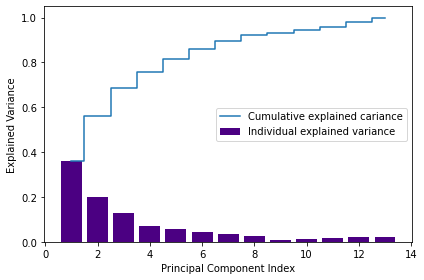

In [34]:
import matplotlib.pyplot as plt

sum_eigen_vals = sum(eigen_vals)
explained_variance_ratio = [eigen_val/sum_eigen_vals for eigen_val in eigen_vals]

cumul_exmplained_variance_ratio = np.cumsum(explained_variance_ratio)

plt.bar(range(1,14), explained_variance_ratio, align='center', color = 'indigo', label='Individual explained variance')
plt.step(range(1,14), cumul_exmplained_variance_ratio, where='mid', label='Cumulative explained cariance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [108]:
# select k eigenvectors corresponding to the k largest eigenvalues (k being the dimensionality of the new feature subspace)

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

def transfer_matrix(k):
     return np.hstack(([eigen_pairs[i][1][:,np.newaxis].real for i in range(k)]))

transf_mat = transfer_matrix(k=3)
transf_mat.shape

# transform a sample from X to z
# i.e. from 13 features to k=3

X_train_std[0].dot(transf_mat)



array([-0.501, -0.587, -0.557])

In [107]:
# transform all training samples by pca transformation
X_train_pca = X_train_std.dot(transf_mat)
X_train_pca.shape, X_train_std.shape

((123, 3), (123, 13))

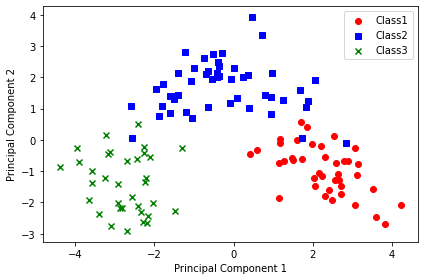

In [61]:
colors = ['r', 'b', 'g']
markers = ['o', 's', 'x']

for label, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==label, 0], X_train_pca[y_train==label, 1], c=color, label=f"Class{label}", marker=marker)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We note that the data is more spread along the first principal component, which is consistent with the fact that 40% of the variance stems from the 1st component. We can also see that a linear classifier will be able to seperate the classes well. 
  
#### PCA in SciKit-Learn

In [62]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X,y, classifier, test_idx=None, resolution=0.02):
    markers = ('o','s', '^','<', '>')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:,1].min() -1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() -1, X[:,1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min,x2_max,resolution))
    
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,lab,alpha=0.25, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[ y == cl, 1],
                    alpha = .8,
                    c=colors[idx],
                    marker=markers[idx],
                    label = f"Class {cl}",
                    edgecolors='black')


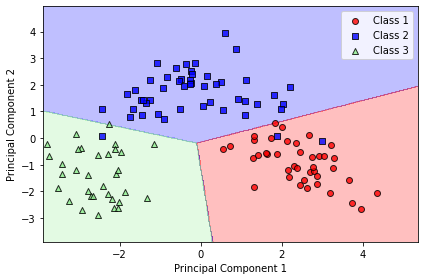

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# initialize PCA transformer and logistic regression predictor

pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='liblinear',penalty='l2')

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# fit the logistic regression model on the reduced dataset

lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


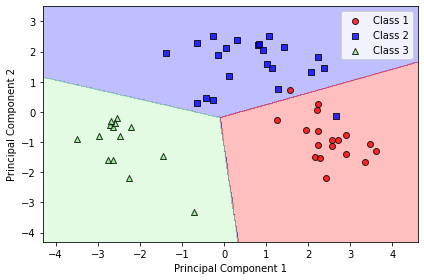

In [64]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [67]:
# to see the variance ratios of the different principal components (eigenvectors), we can initialize
# the PCA class with n_components=None
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36089927, 0.19883055, 0.12639446, 0.07251624, 0.05730611,
       0.04444896, 0.03591537, 0.02720895, 0.02187426, 0.01974171,
       0.01537778, 0.01169779, 0.00778856])

Tracking the contributions of the original features to the principal components through ***loadings***.  

The factor loadings are compouted by **scaling the eigenvectors by the square root of the eigenvalues**. The resulting values can tehn be interpreted as the correlation between the orignal features and the principal component.


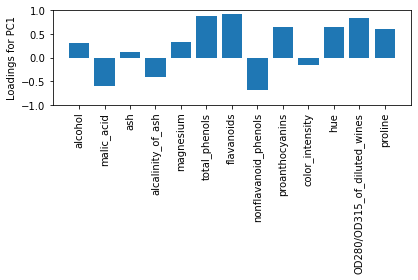

In [68]:
loadings = eigen_vecs*np.sqrt(eigen_vals)

fig, ax = plt.subplots()
ax.bar(range(13), loadings[:,0], align='center')
ax.set_ylabel('Loadings for PC1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1,1])
plt.tight_layout()
plt.show()
# these are obtained by our own implementation

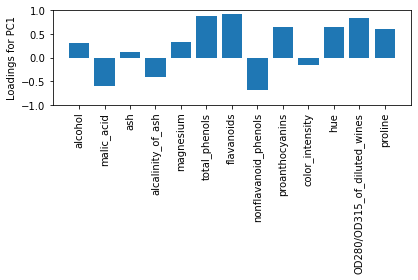

In [69]:
# getting loadings from scikit-learn

sklearn_loadings = pca.components_.T*np.sqrt(pca.explained_variance_)
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:,0], align='center')
ax.set_ylabel('Loadings for PC1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1,1])
plt.tight_layout()
plt.show()



## Linear Discriminant Analysis
A feature extraction technique to increase computational efficiency & reduce the degree of overfitting due to the curse of dimensionality.  
It tries to find the feature subspace that optimizes class seperability

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# get standardized train and test data

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
sc = StandardScaler()
X_std = sc.fit_transform(X=X)

X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=1)

np.set_printoptions(precision=3)

# compute the d-dimensional mean vector for each class label
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'Mean Vector #{label}: {mean_vecs[label-1]}\n')

Mean Vector #1: [ 0.89  -0.269  0.385 -0.63   0.51   0.896  0.949 -0.56   0.522  0.212
  0.486  0.773  1.169]

Mean Vector #2: [-0.971 -0.3   -0.342  0.365 -0.43  -0.139  0.013  0.196 -0.014 -0.859
  0.356  0.232 -0.783]

Mean Vector #3: [ 0.191  1.13   0.216  0.539  0.021 -0.992 -1.26   0.715 -0.738  1.006
 -1.176 -1.33  -0.299]



In [76]:
# calculate the within-class scatter matrix Sw

dimension = 13

Sw = np.zeros((dimension, dimension))

for label, mean_vec in zip(range(1,4), mean_vecs):
    Si = np.zeros((dimension, dimension))
    # sum all variances between examples and feature means
    for row in X_train_std[y_train == label]:
        row, mean_vec = row.reshape(dimension,1), mean_vec.reshape(dimension,1)
        Si += (row - mean_vec).dot((row - mean_vec).T)
    # sum all class variances to construct within-class matrix
    Sw += Si

print('Within-class scatter matrix: ', f'{Sw.shape[0]}x{Sw.shape[1]}')
print('Class label distribution: ', np.bincount(y_train)[1:])


Within-class scatter matrix:  13x13
Class label distribution:  [40 49 34]


The within-class assumes the class labels in the training dataset is normally distributed. We see that isn't the case and thus we weant to scale the individual scatter matrices Si before we sum into the within-class matrix. Dividing by number of samples to normalize essentially makes it into the covariance matrix. Thus, we can do the following

In [81]:
dimension = 13

Sw = np.zeros((dimension, dimension))

for label in range(1,4):
    Si = np.zeros((dimension, dimension))
    # sum all variances between examples and feature means
    for row in X_train_std[y_train == label]:
        Si += np.cov(X_train_std[y_train == label].T)
    # sum all class variances to construct within-class matrix
    Sw += Si

print('Scaed within-class scatter matrix: ', f'{Sw.shape[0]}x{Sw.shape[1]}')


Scaed within-class scatter matrix:  13x13


In [86]:
# calculate the between class scatter matrix

mean_overall = np.mean(X_train_std, axis=0).reshape(dimension,1)
Sb = np.zeros((dimension,dimension))

for i, mean_vec in enumerate(mean_vecs):
    n = len(X_train_std[y_train == i+1])
    Sb += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print(f'Between-class scatter matrix: {Sb.shape[0]}x{Sb.shape[1]}')


Between-class scatter matrix: 13x13


Compute the eigenvalues and eigenvectors of $S_{w}^{-1}S_{b}$

In [93]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key = lambda k: k[0], reverse=True)

print('Eigenvalues in descending order: ')

for i, pair in enumerate(eigen_pairs):
    print(f'({i+1}) Value: {pair[0]}')

Eigenvalues in descending order: 
(1) Value: 123.52124461658899
(2) Value: 0.6534796820173884
(3) Value: 2.0866769592735697e-14
(4) Value: 1.2926509418855571e-14
(5) Value: 8.939140642526421e-15
(6) Value: 8.939140642526421e-15
(7) Value: 7.666403742297005e-15
(8) Value: 7.666403742297005e-15
(9) Value: 7.016966456850224e-15
(10) Value: 7.016966456850224e-15
(11) Value: 4.6013211129605975e-15
(12) Value: 4.6013211129605975e-15
(13) Value: 9.209146519390378e-16


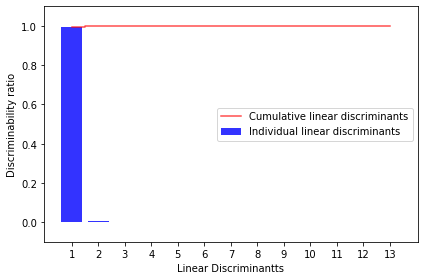

In [101]:
eigen_vals_sum = sum(eigen_vals.real)
linear_discriminants = [(i/eigen_vals_sum) for i in sorted(eigen_vals.real, reverse=True)]
cumsum_discriminants = np.cumsum(linear_discriminants)

plt.bar(range(1,14), linear_discriminants, align='center', label='Individual linear discriminants', color='b', alpha=0.8)
plt.step(range(1,14), cumsum_discriminants, where='mid', label= 'Cumulative linear discriminants', color='r', alpha = 0.7)
plt.xlabel('Linear Discriminantts')
plt.ylabel('Discriminability ratio')
plt.xticks([i+1 for i in range(len(eigen_vals))])
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()



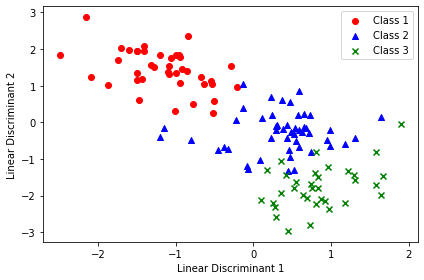

In [127]:
T = transfer_matrix(k=2)

X_train_lda = X_train_std.dot(T)

colors = ['r', 'b', 'g']
markers = ['o', '^', 'x']

for label, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==label,0],X_train_lda[y_train==label,1]*(-1),c=color, marker=marker, label = f'Class {label}')

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

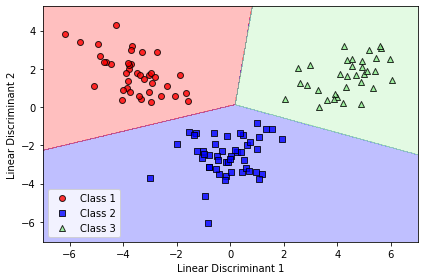

In [143]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std*(-1), y_train)

lr = LogisticRegression(multi_class='ovr', random_state=1, penalty='l2', solver='liblinear')
lr.fit(X_train_lda*(-1), y_train)

plot_decision_regions(X_train_lda*(-1), y_train, classifier=lr)

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.xlim([-7,7])
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Percentage correct: 96.3%
Misclassified 2


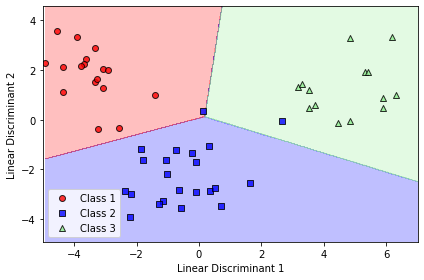

In [152]:
X_test_lda = lda.transform(X_test_std)

print(f'Percentage correct: {np.round(lr.score(lda.transform(X_test_std), y_test),3)*100}%')
y_pred = lr.predict(X_test_lda)
print(f'Misclassified {(y_pred != y_test).sum()}')

plot_decision_regions(X_test_lda, y_test, classifier=lr)

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.xlim([-5,7])
plt.legend(loc='best')
plt.tight_layout()
plt.show()